In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import cv2
import glob
from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
data_path = '../Data/cohn-kanade-images'
emotion_path = '../Data/Emotion'
facs_path = '../Data/FACS'
landmarks_path = '../Data/Landmarks'
crop_path = '../Data/Crop'

all_image_files = glob.glob(data_path+'/**/*.png', recursive=True)
all_emotion_files = glob.glob(emotion_path+'/**/*.txt', recursive=True)
all_facs_files = glob.glob(facs_path+'/**/*.txt', recursive=True)
all_landmarks_files = glob.glob(landmarks_path+'/**/*.txt', recursive=True)

In [3]:
# ONLY 327 of the 593 sequences have emotion sequences
# 0-7 (i.e. 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise)
all_emotions = {0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 
                4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}
all_image_files[:5], all_emotion_files[:5], all_facs_files[:5], all_landmarks_files[:5]

(['../Data/cohn-kanade-images/S005/001/S005_001_00000001.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000002.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000003.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000004.png',
  '../Data/cohn-kanade-images/S005/001/S005_001_00000005.png'],
 ['../Data/Emotion/S005/001/S005_001_00000011_emotion.txt',
  '../Data/Emotion/S010/002/S010_002_00000014_emotion.txt',
  '../Data/Emotion/S010/004/S010_004_00000019_emotion.txt',
  '../Data/Emotion/S010/006/S010_006_00000015_emotion.txt',
  '../Data/Emotion/S011/001/S011_001_00000016_emotion.txt'],
 ['../Data/FACS/S005/001/S005_001_00000011_facs.txt',
  '../Data/FACS/S010/001/S010_001_00000014_facs.txt',
  '../Data/FACS/S010/002/S010_002_00000014_facs.txt',
  '../Data/FACS/S010/003/S010_003_00000018_facs.txt',
  '../Data/FACS/S010/004/S010_004_00000019_facs.txt'],
 ['../Data/Landmarks/S005/001/S005_001_00000001_landmarks.txt',
  '../Data/Landmarks/S005/001/S005_001_00000002_

In [4]:
pd.set_option('display.max_colwidth', -1)

crop_imsize = 350

def get_thumbnail(path):
    ''' function to read image'''
    i = Image.open(path)
#     i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    ''' function to encode image in base64 '''
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    ''' function to return html code for printing image in dataframe '''
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(im))

def crop_image_formatter(im):
    ''' function to read cropped image from numpy array '''
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(Image.fromarray(np.uint8(im))))

face_det = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        gray = gray[y:y+h, x:x+w] #Cut the frame to size
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

def print_metrics(y_test, y_pred):
    ''' just a function from data science for printing '''
    labels = dict(all_emotions)
    del labels[0]
    
    print(labels)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Classification Report: \n', classification_report(y_test, y_pred, 
                                                             target_names=[l for l in labels.values()]))
    
    conf_mat = confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(len(labels)), [l for l in labels.values()], rotation=90)
    _ = plt.yticks(range(len(labels)), [l for l in labels.values()])

# Creating Dataframe for images dataset

In [5]:
# reading all the image files, and then finding corresponding landmark, facs files and save them in a dictionary
image_dict = {}

for i_im in all_image_files:
    im_dict = {}
    im_folder = i_im.rsplit('/', 1)[0]
    if im_folder not in image_dict.keys():
        im_files = glob.glob(im_folder+'/*.png')
        im_dict['emotion'] = im_files[-1]
        im_dict['neutral'] = im_files[0]

        im_folder_base = im_files[-1].split('/', 3)[-1].rsplit('/', 1)[0]
        facs_folder = facs_path + '/' + im_folder_base
        emotion_folder = emotion_path + '/' + im_folder_base
        landmarks_folder = landmarks_path + '/' + im_folder_base

        facs_file = glob.glob(facs_folder+'/*.txt')[0]
        emotion_file = glob.glob(emotion_folder+'/*.txt')
        neutral_landmarks_file = glob.glob(landmarks_folder+'/*.txt')[0]
        emotion_landmarks_file = glob.glob(landmarks_folder+'/*.txt')[-1]

        with open(facs_file) as f:
            data = f.read()
            im_dict['facs'] = np.array([list(map(float, i.split())) for i in data.strip().split('\n')])

        if len(emotion_file) > 0:
            emotion_file = emotion_file[0]
            with open(emotion_file) as f:
                data = f.read()
                im_dict['label'] = int(float(data))
                im_dict['label_str'] = all_emotions[im_dict['label']]

        with open(neutral_landmarks_file) as f:
            data = f.read()
            im_dict['neutral_landmarks'] = np.array([list(map(float, 
                                                     i.split())) for i in data.strip().split('\n')])

        with open(emotion_landmarks_file) as f:
            data = f.read()
            im_dict['emotion_landmarks'] = np.array([list(map(float, 
                                                     i.split())) for i in data.strip().split('\n')])

    #     print(im_dict)
        image_dict[im_folder] = (im_dict)

# print(len(image_dict))

In [6]:
# converting that dictionary to pandas dataframe, and applying operations on certain columns
df_images = pd.DataFrame.from_dict(image_dict).T
df_images.to_csv('ImageDict.csv', index=False)

# function to store images in df column
df_images['im_emotion'] = df_images.emotion.map(lambda f: get_thumbnail(f))
df_images['im_neutral'] = df_images.neutral.map(lambda f: get_thumbnail(f))

# function to detect faces and crop images and store in df, and also shift landmarks to cropped face
# df_images['im_emotion_crop'] = df_images.emotion.map(lambda f: detect_face(f))
# df_images['im_neutral_crop'] = df_images.neutral.map(lambda f: detect_face(f))
emotion_crop_tuple = df_images.apply(lambda row: detect_face(row.emotion, 
                                                             row.emotion_landmarks), axis=1)
df_images[['im_emotion_crop', 'emotion_crop_landmarks']] = pd.DataFrame(emotion_crop_tuple.tolist(), index=emotion_crop_tuple.index)
neutral_crop_tuple = df_images.apply(lambda row: detect_face(row.neutral, 
                                                             row.neutral_landmarks), axis=1)
df_images[['im_neutral_crop', 'neutral_crop_landmarks']] = pd.DataFrame(neutral_crop_tuple.tolist(), index=neutral_crop_tuple.index)

df_images.head(3)

emotion  \
../Data/cohn-kanade-images/S005/001  ../Data/cohn-kanade-images/S005/001/S005_001_00000011.png   
../Data/cohn-kanade-images/S010/001  ../Data/cohn-kanade-images/S010/001/S010_001_00000014.png   
../Data/cohn-kanade-images/S010/002  ../Data/cohn-kanade-images/S010/002/S010_002_00000014.png   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       emotion_landmarks  \
../Data/cohn-kanade-images/S005/001  [[217.79271, 217.08805], [216.88443, 254.86448], [223.55064, 291.71873], [238.07867, 326.44699], [254.73368, 360.31063], [280.92616, 387.08162], [311.85609, 408.21462], [345.3864, 425.31455], [382.35779, 428.51798], [416.80136, 421.23537], [447.64806, 403.64693], [474.16684, 380.34877], [497.57905, 354.15979], [512.00839, 321.95562], [516.59206, 286.88171], [518.1624, 251.70528], [518.69509, 216.55438], [247.9393, 177.99485], [270.63539, 166.95336], [295.19599, 163.15286], [319.97857, 166.66386], [341.04563, 179.59488], [394.24914, 180.65987], [415.04944, 164.897], [439.61374, 155.97562], [465.56984, 154.95874], [488.87095, 165.42771], [374.03129, 204.59779], [374.32907, 228.32552], [375.7371, 251.7786], [375.09436, 275.35806], [344.23472, 284.3984], [359.7385, 294.08133], [377.2214, 298.23257], [394.03285, 293.98807], [408.07937, 283.86645], [280.10359, 206.43625], [298.09091, 198.82177], [317.82903, 198.47148], [336.25483, 204.59654], [317.48721, 205.10701], [298.70708, 205.6972], [409.14496, 201.9353], [426.33728, 193.84215], [445.15916, 191.85273], [463.4119, 196.08312], [445.26575, 198.11206], [427.08675, 199.19266], [329.87126, 333.87782], [341.12262, 318.82401], [357.93863, 310.74505], [375.62523, 315.25751], [393.492, 310.913], [410.64352, 318.04754], [423.50738, 331.21837], [414.4107, 345.90805], [398.0033, 352.24676], [380.41417, 353.56281], [360.895, 352.87743], [342.39096, 347.90027], [341.46022, 330.43663], [353.04918, 330.16505], [376.15727, 331.75025], [399.97572, 327.51749], [411.74155, 327.77521], [399.62511, 328.03292], [376.1574, 331.74992], [352.81773, 330.70822]]            
../Data/cohn-kanade-images/S010/001  [[264.53217, 230.55268], [263.78732, 263.50114], [262.75202, 296.47702], [265.08061, 329.01464], [278.30305, 359.01191], [298.90747, 384.59772], [324.91007, 404.00507], [355.45973, 416.2458], [387.7675, 415.79388], [419.52399, 414.23741], [448.34073, 401.26421], [472.04832, 380.09165], [490.87713, 354.18362], [500.72561, 324.2775], [50

,label,im_neutral,im_neutral_crop,im_emotion,im_emotion_crop
../Data/cohn-kanade-images/S005/001,3,,,,
../Data/cohn-kanade-images/S010/001,NaN,,,,
../Data/cohn-kanade-images/S010/002,7,,,,
../Data/cohn-kanade-images/S010/003,NaN,,,,
../Data/cohn-kanade-images/S010/004,1,,,,

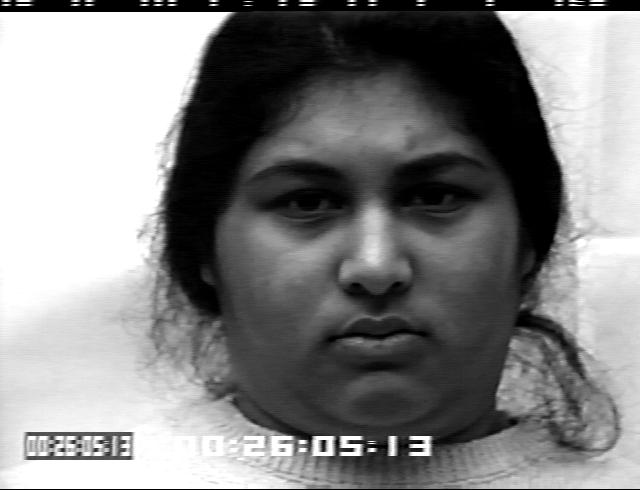
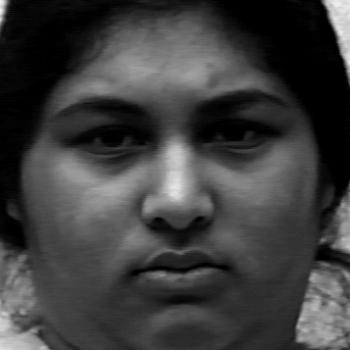
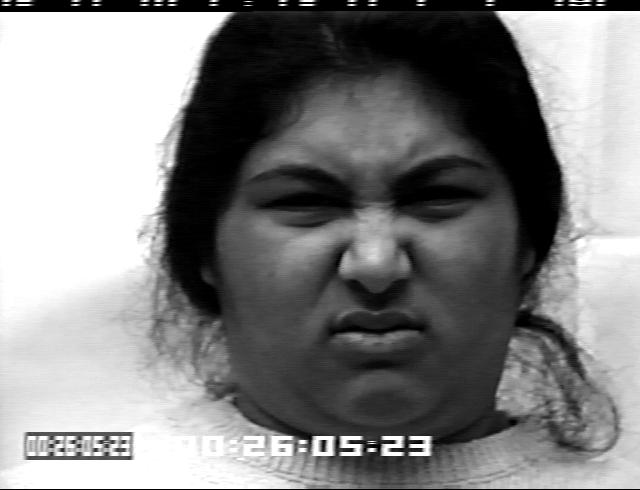
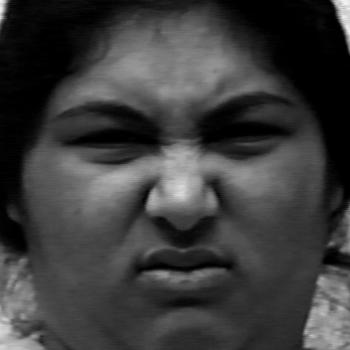
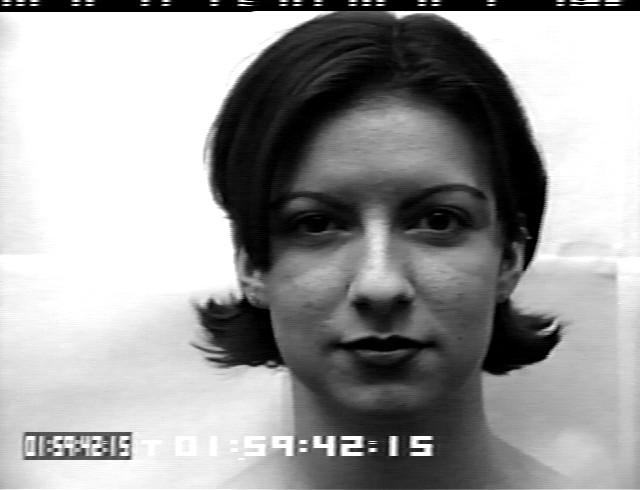
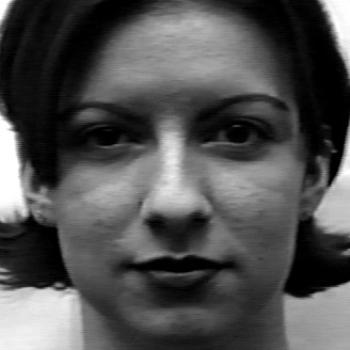
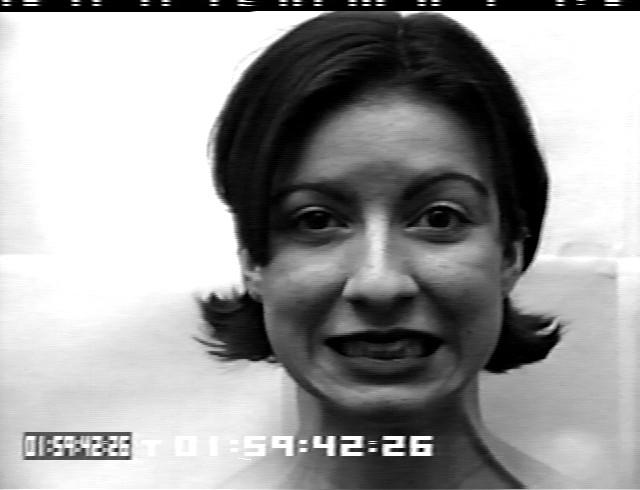
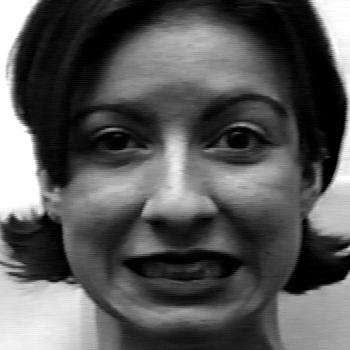
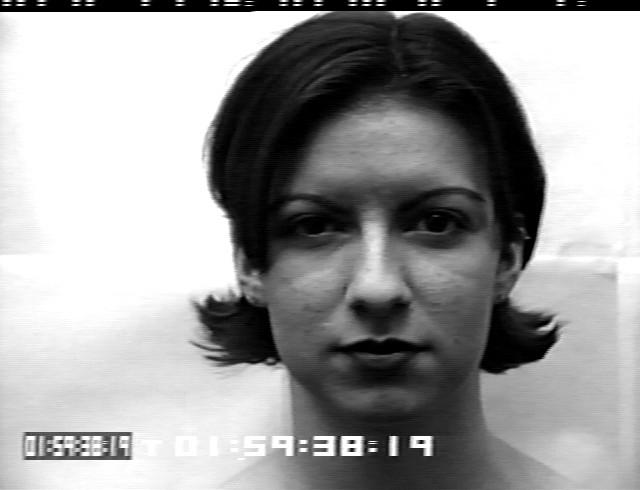
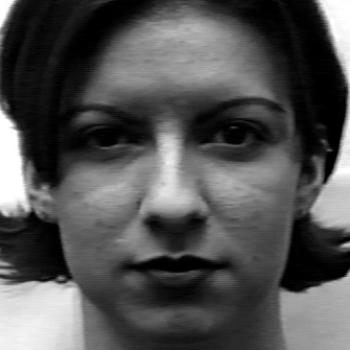
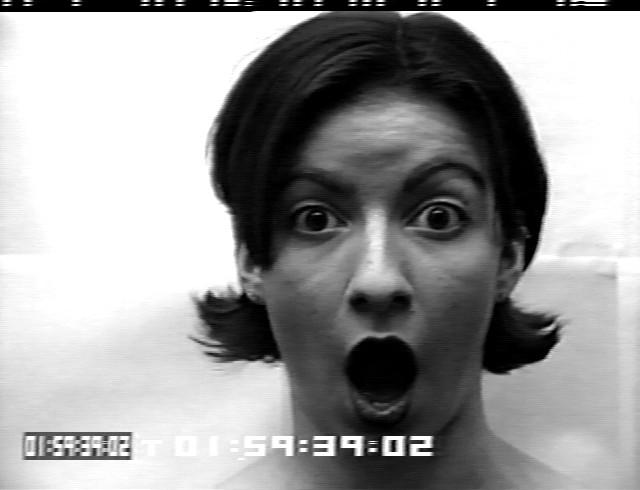
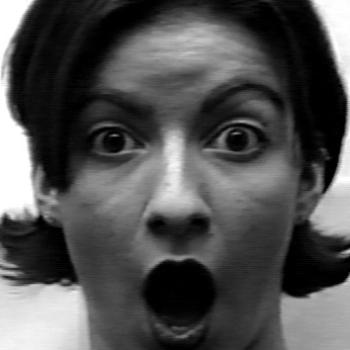
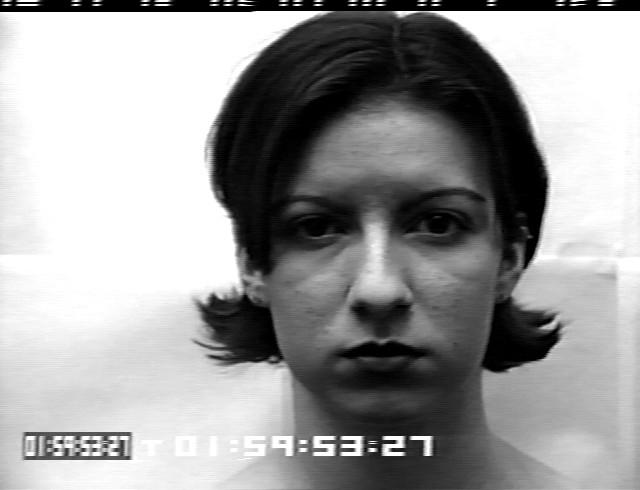
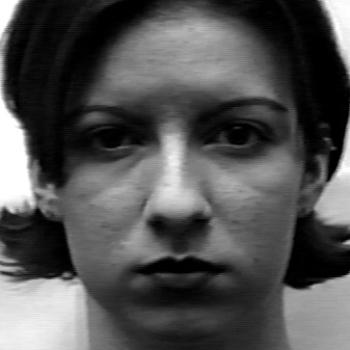
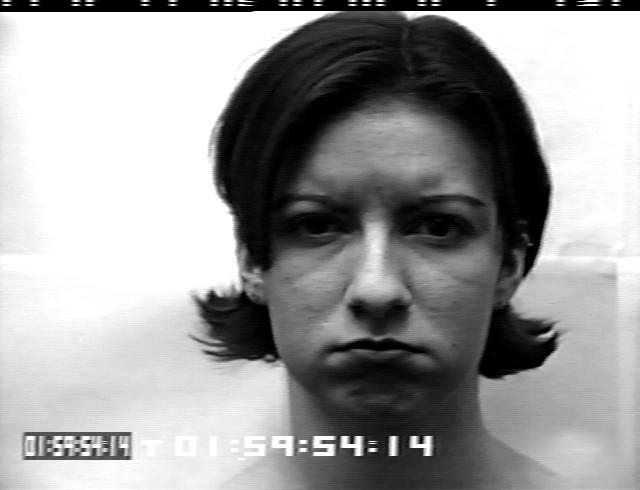
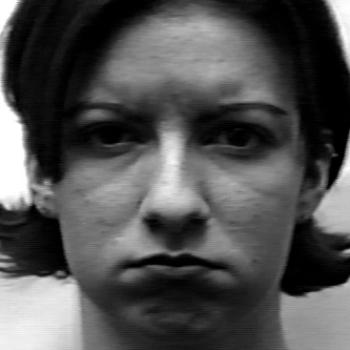
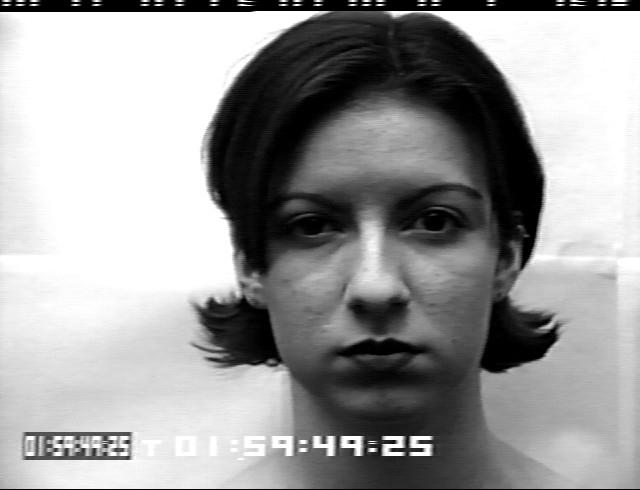
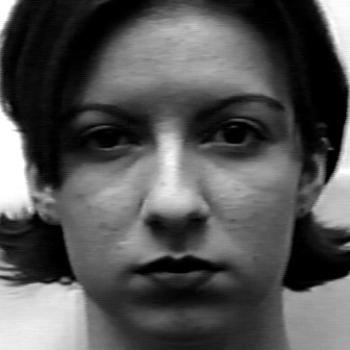
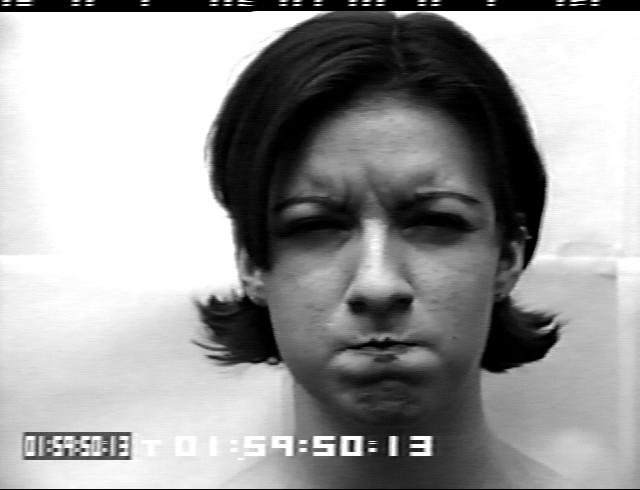
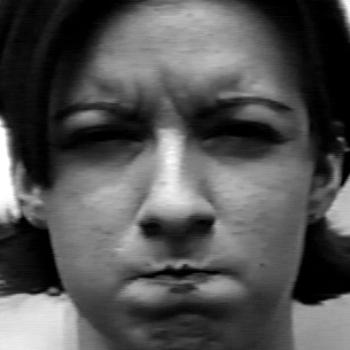

In [7]:
# displaying PIL.Image objects embedded in dataframe
HTML(df_images[['label', 'im_neutral', 'im_neutral_crop', 'im_emotion', 
                'im_emotion_crop']].head(5).to_html(formatters={'im_neutral': image_formatter, 
                                                                'im_emotion': image_formatter,
                                                                'im_neutral_crop': crop_image_formatter, 
                                                                'im_emotion_crop': crop_image_formatter}, escape=False))
# HTML(image_formatter(df_images[['im_neutral']].head(1)['im_neutral'][0]))
# df_images[['im_neutral']].head(1)['im_neutral'][0]

## Checking if landmarks fit well on the original image and cropped image that are stored in df

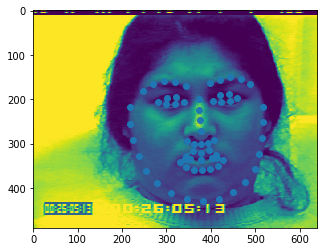

In [9]:
ld, im = df_images.head(1)[['neutral_landmarks', 'neutral']].values[0]
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

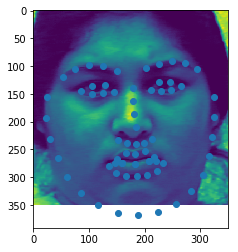

In [10]:
ld, im = df_images.head(1)[['neutral_crop_landmarks', 'im_neutral_crop']].values[0]
implot = plt.imshow(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

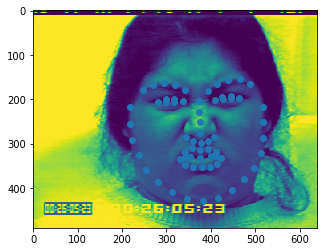

In [11]:
ld, im = df_images.head(1)[['emotion_landmarks', 'emotion']].values[0]
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

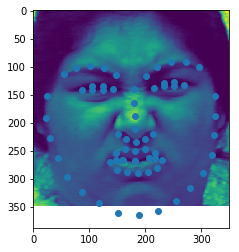

In [12]:
ld, im = df_images.head(1)[['emotion_crop_landmarks', 'im_emotion_crop']].values[0]
implot = plt.imshow(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

### Trial code for checking landmark after cropping image, Code already added in df above, ignore few cells below

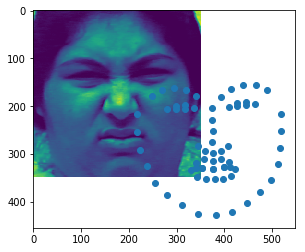

In [14]:
ld, im = df_images.head(1)[['emotion_landmarks', 'emotion']].values[0]

frame = cv2.imread(im) #Open image
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
face_det = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, w, h) in face:
    gray = gray[y:y+h, x:x+w] #Cut the frame to size
    
try:
    output = cv2.resize(gray, (350, 350))
except:
    output = gray
plt.imshow(Image.fromarray(np.uint8(output)))
plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

In [15]:
ld = np.array(ld)

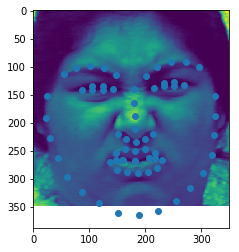

In [16]:
plt.imshow(Image.fromarray(np.uint8(output)))
plt.scatter(ld[:,0]-x, ld[:, 1]-y)

### Trial code for flipping image, final code added below

In [17]:
df_cnn = df_images[~df_images['label'].isna()][['im_emotion_crop', 'label']]

In [18]:
X, y = df_cnn['im_emotion_crop'], df_cnn['label']

In [19]:
X.shape, y.shape

((327,), (327,))

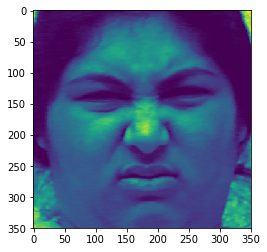

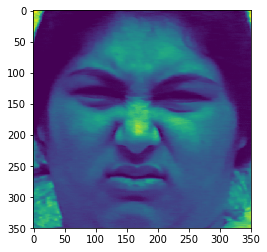

In [20]:
plt.imshow(X[0])
plt.show()
plt.imshow(np.fliplr(X[0]))

# Creating Emotion images and label as dataset
### Note: Neutral faces are not taken into account

# Flipping images and combining to increase dataset

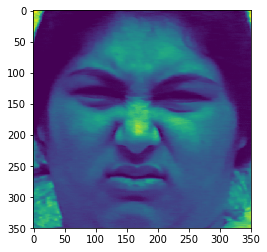

In [21]:
X_flip = X.apply(lambda x: np.fliplr(x))
plt.imshow(X_flip[0])

In [22]:
# X_total = X.reset_index(drop=True)
# y_total = to_categorical(y)
X_total = pd.concat([X.reset_index(drop=True), X_flip.reset_index(drop=True)], axis=0).reset_index(drop=True)
X_total = np.array([i for i in X_total])
X_total = X_total.reshape(X_total.shape[0], crop_imsize, crop_imsize, 1)
y_total = to_categorical(pd.concat([y, y], axis=0).reset_index(drop=True))

X_total.shape, y_total.shape

((654, 350, 350, 1), (654, 8))

In [23]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((523, 350, 350, 1), (131, 350, 350, 1), (523, 8), (131, 8))

# Creating keras CNN model (Doesn't work well, stopped after running a while)

In [19]:
# #create model
# model = Sequential()

# #add model layers
# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(crop_imsize, crop_imsize, 1)))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(Conv2D(16, kernel_size=3, activation='relu'))
# model.add(Flatten())
# model.add(Dense(8, activation='softmax'))

# #compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(crop_imsize, crop_imsize, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=100)

Train on 523 samples, validate on 131 samples
Epoch 1/5
523/523 [==============================] - 1950s 4s/step - loss: 13.3497 - acc: 0.1568 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 2/5
523/523 [==============================] - 1847s 4s/step - loss: 13.8683 - acc: 0.1396 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 3/5
523/523 [==============================] - 1784s 3s/step - loss: 13.8683 - acc: 0.1396 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 4/5
523/523 [==============================] - 1752s 3s/step - loss: 13.8683 - acc: 0.1396 - val_loss: 14.0264 - val_acc: 0.1298
Epoch 5/5


KeyboardInterrupt: 

In [61]:
y_pred = model.predict(X_test)

{1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}
Accuracy:  0.129770992366
Classification Report: 
               precision    recall  f1-score   support

       anger       0.13      1.00      0.23        17
    contempt       0.00      0.00      0.00         7
     disgust       0.00      0.00      0.00        28
        fear       0.00      0.00      0.00        13
       happy       0.00      0.00      0.00        22
     sadness       0.00      0.00      0.00        13
    surprise       0.00      0.00      0.00        31

   micro avg       0.13      0.13      0.13       131
   macro avg       0.02      0.14      0.03       131
weighted avg       0.02      0.13      0.03       131



/Users/apple/anaconda3/envs/BML/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


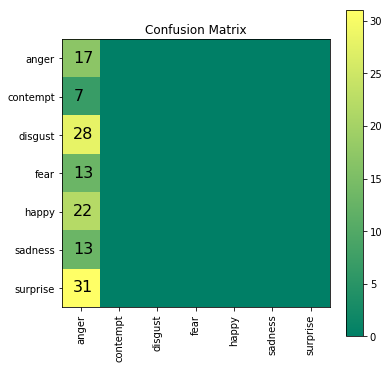

In [62]:
print_metrics(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [42]:
y_test.argmax(axis=1)

array([4, 7, 7, 7, 5, 6, 3, 3, 7, 7, 7, 7, 1, 7, 3, 4, 4, 7, 7, 4, 1, 6, 1,
       3, 1, 6, 3, 7, 2, 7, 5, 1, 5, 7, 7, 7, 1, 5, 2, 4, 5, 7, 5, 7, 7, 7,
       7, 5, 4, 4, 1, 5, 3, 2, 3, 6, 3, 1, 6, 7, 5, 1, 3, 6, 5, 3, 7, 3, 7,
       5, 3, 3, 5, 3, 3, 3, 1, 6, 1, 4, 3, 4, 1, 4, 5, 3, 6, 6, 5, 4, 3, 3,
       7, 3, 3, 7, 6, 5, 7, 4, 5, 1, 1, 7, 5, 1, 2, 2, 3, 2, 3, 3, 5, 6, 3,
       7, 7, 7, 4, 5, 3, 5, 5, 1, 7, 6, 2, 6, 1, 3, 5])

In [54]:
y_test[0]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.], dtype=float32)

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 200, 200, 128)     1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 128)     0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100, 128)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 98, 98, 64)        73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 47, 47, 32)        18464     
__________

# Using cv2 Fisher Face Recognizer

In [24]:
fishface = cv2.face.FisherFaceRecognizer_create() #Initialize fisher face classifier
fishface.train(X_train, np.asarray(y_train.argmax(axis=1)))
correct = 0
incorrect = 0
for cnt, image in enumerate(X_test):
    pred, conf = fishface.predict(image)
    if pred == y_test.argmax(axis=1)[cnt]:
        correct += 1
#         cnt += 1
    else:
        incorrect += 1
#         cnt += 1
print((100*correct)/(correct + incorrect))

83.96946564885496


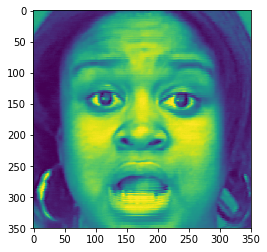

In [26]:
plt.imshow(X_test[10].reshape(crop_imsize,crop_imsize))

In [27]:
fishface.predict(X_test[10]), y_test[10]

((7, 684.380844910426),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32))

In [28]:
all_emotions

{0: 'neutral',
 1: 'anger',
 2: 'contempt',
 3: 'disgust',
 4: 'fear',
 5: 'happy',
 6: 'sadness',
 7: 'surprise'}

# Using landmarks for detecting emotion (In progress, not done)

In [29]:
df_images.columns

Index(['emotion', 'emotion_landmarks', 'facs', 'label', 'label_str', 'neutral',
       'neutral_landmarks', 'im_emotion', 'im_neutral', 'im_emotion_crop',
       'emotion_crop_landmarks', 'im_neutral_crop', 'neutral_crop_landmarks'],
      dtype='object')

In [30]:
df_landmarks = df_images[~df_images['label'].isna()][['emotion_landmarks', 'label']]
X, y = df_landmarks['emotion_landmarks'], df_landmarks['label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((261,), (66,), (261,), (66,))

In [32]:
X_train.head(2).values

array([ array([[ 198.89376,  205.95963],
       [ 200.50706,  237.32571],
       [ 203.74478,  268.55796],
       [ 207.81438,  299.61563],
       [ 216.81982,  329.47673],
       [ 231.1299 ,  357.49224],
       [ 252.60005,  379.95898],
       [ 279.21103,  396.42287],
       [ 309.42908,  403.02328],
       [ 337.15088,  398.89028],
       [ 360.7263 ,  383.7431 ],
       [ 379.8834 ,  363.00399],
       [ 393.02392,  338.12898],
       [ 406.36207,  313.23775],
       [ 415.2764 ,  286.47706],
       [ 421.53595,  259.1423 ],
       [ 427.30659,  231.61451],
       [ 231.68356,  140.51914],
       [ 242.44672,  131.31718],
       [ 256.62319,  128.04518],
       [ 271.26905,  127.19176],
       [ 285.8512 ,  127.01727],
       [ 355.58616,  130.9207 ],
       [ 372.40883,  131.19857],
       [ 388.86269,  135.62716],
       [ 403.90631,  143.38176],
       [ 414.63133,  156.18361],
       [ 319.13203,  177.32912],
       [ 318.86584,  193.82502],
       [ 318.37131,  210.1231 ],
  

In [33]:
[i[0][0] for i in X_train], [i[0][1] for i in X_train]#, [i[1] for i in X_train.head(1).values[0]]

([198.89375999999999,
  240.91247000000001,
  256.23543000000001,
  163.71654000000001,
  187.12267,
  191.23697999999999,
  202.72574,
  189.63074,
  191.8381,
  177.80572000000001,
  153.75348,
  226.34608,
  186.55708999999999,
  155.49538000000001,
  174.95071999999999,
  207.79234,
  217.94381000000001,
  199.65132,
  192.80365,
  179.85314,
  193.99790999999999,
  136.96641,
  189.40888000000001,
  201.23099999999999,
  253.11115000000001,
  210.33404999999999,
  206.74329,
  229.37446,
  203.29067000000001,
  208.30815999999999,
  211.77520000000001,
  172.80083999999999,
  202.11528000000001,
  187.18568999999999,
  211.94732999999999,
  140.27582000000001,
  236.44988000000001,
  178.90100000000001,
  221.30548999999999,
  198.84065000000001,
  201.02187000000001,
  192.87701000000001,
  193.68199000000001,
  164.72540000000001,
  244.87540999999999,
  210.44308000000001,
  234.07264000000001,
  193.28335000000001,
  196.18192999999999,
  233.49961999999999,
  181.158179999999

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt = DecisionTreeClassifier()
res = cross_val_score(dt, X, y, cv=10)
print(res)

/Users/apple/anaconda3/envs/BML/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: setting an array element with a sequence.